## Setup

In [1]:
import pandas as pd
import numpy as np
import sys
pd.set_option('display.max_columns',30)
import scipy.stats as ss
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.optimize import curve_fit
import scipy.interpolate

In [2]:
df = pd.read_csv('covid19daily.csv')
df['date'] = pd.to_datetime(df.Date,dayfirst=True)
df = df.drop(['Date'],axis=1)
#rearrange
cols = list(df.columns)
cols.insert(0,cols.pop())
df = df[cols]

In [3]:
df.columns

Index(['date', 'NewPositiveConfirmed', 'NewPositiveProbable',
       'DailyPeopleTested', 'Current_Total_Hospitalized',
       'TotalHospitalizedToDate', 'Current_Total_ICU', 'Total_ICU_ToDate',
       'Cumulative_Deaths', 'RecoveredToDate'],
      dtype='object')

In [4]:
# Drop last row (today's data as it is incomplete)
df = df[:-1]

## UPDATES:
March 15 - April 5, 2020
Up to April 5, reporting was only New Positive tests, Daily Negative tests. Recovered, Current Hospitalized, Current ICU and total deaths were extracted from textual reports.

April 6, 2020

April 6, the Positive Tests were split into Confirmed and Probable. An additional table showing total hospitalized to date and ICU to date were added to the Province's data reporting page.  
Additionally, starting April 6, daily reporting from here will not show the current day's date, as reporting for the current day is incomplete and gives a false picture.

April 7, 2020:  
Alberta Health said the temporary decline in testing is the delayed result of the changes implemented on March 23. At that time, Alberta shifted its priorities from testing people returning from travel after March 12 who had mild symptoms to testing anyone who is symptomatic and:  
* Is hospitalized with respiratory illness
* Is a resident in a continuing care home or similar facility
* Has returned from travelling abroad between March 8 and March 12 (before the self-isolation protocols were in place)
* Is a health-care worker with respiratory symptoms.
“We expanded Alberta’s testing criteria [Monday] and expect testing numbers will rise back to maximum capacity very soon,” spokesperson Tom McMillan told Global News in an email.  

Also, note that the testing numbers on Alberta Health which were previously reported as 'Negative tests' are now 'Total People Tested'. This has been accounted for in my calculations.

# Calculated Columns

In [5]:
df['NewPositive'] = df['NewPositiveConfirmed']+df['NewPositiveProbable']  # include the probable cases in with the confirmed 

In [6]:
df['TotalPositive'] = df['NewPositive'].cumsum()

In [7]:
df['TotalTests'] = df.DailyPeopleTested

In [8]:
# Note My Cumulative number of tests won't match province because there were approx 378 tests carried out prior to March 6 which are not reflected here
df['CumPeopleTested']=df['TotalTests'].cumsum()

In [9]:
# Alberta Population from https://economicdashboard.alberta.ca/Population
totalpop = 4413146

In [10]:
df['percentTestsperPop'] = (df.CumPeopleTested)/totalpop*100

In [11]:
df['percTestperDayperPop'] = df.TotalTests/totalpop*100

In [12]:
df['percHospPerPositiveTest'] = df.Current_Total_Hospitalized/df.TotalPositive*100

In [13]:
df['percICUPerPostitiveTest'] = df.Current_Total_ICU/df.TotalPositive*100

In [14]:
df['percICUPerHospitalized'] = df.Current_Total_ICU/df.Current_Total_Hospitalized*100

In [15]:
# CFR = Case Fatality Rate
df['perc_CFR'] = df.Cumulative_Deaths/df.TotalPositive*100

In [16]:
df['perc_MortalityRate'] = df.Cumulative_Deaths/totalpop*100

# Modeling logarithmic growth

In [17]:
df.tail()

,date,NewPositiveConfirmed,NewPositiveProbable,DailyPeopleTested,Current_Total_Hospitalized,TotalHospitalizedToDate,Current_Total_ICU,Total_ICU_ToDate,Cumulative_Deaths,RecoveredToDate,NewPositive,TotalPositive,TotalTests,CumPeopleTested,percentTestsperPop,percTestperDayperPop,percHospPerPositiveTest,percICUPerPostitiveTest,percICUPerHospitalized,perc_CFR,perc_MortalityRate
42,2020-04-17,203,33,4926,57,138.0,14,37.0,62,1117,236,2382,4926,91130,2.064967,0.111621,2.392947,0.587741,24.561404,2.602855,0.001405
43,2020-04-18,175,21,3582,49,135.0,16,38.0,64,1160,196,2578,3582,94712,2.146133,0.081167,1.900698,0.620636,32.653061,2.482545,0.001450
44,2020-04-19,185,16,4062,52,141.0,19,39.0,65,1197,201,2779,4062,98774,2.238177,0.092043,1.871177,0.683699,36.538462,2.338971,0.001473
45,2020-04-20,179,20,3810,52,149.0,18,40.0,65,1229,199,2978,3810,102584,2.324510,0.086333,1.746138,0.604433,34.615385,2.182673,0.001473
46,2020-04-21,252,20,4140,48,156.0,20,44.0,66,1272,272,3250,4140,106724,2.418320,0.093811,1.476923,0.615385,41.666667,2.030769,0.001496


# Plots

## Fit for log/log plot

In [18]:
def llfunc(x,a,b):
    return 10**(a*np.log10(x)+b)

In [19]:
# Fit whole range of data
popt,pcov = curve_fit(llfunc,df.TotalPositive,df.NewPositive)
popt

array([ 1.10229503, -1.50021168])

In [20]:
# Fit all x except last few points (if indeed they are 'dropping off')
x2 = df.TotalPositive[df.TotalPositive<600]
y2 = df.NewPositive[df.TotalPositive<600]
p2opt,p2cov = curve_fit(llfunc,x2,y2)
p2opt

array([0.65169294, 0.04389322])

## Calculate Transmission Rate

In [21]:
def transmission_rate(x,a,b):
    return 10**(a*x+b)

def calc_rsq(f,x,y,popt):
    ss_res = np.dot((y-f(x,*popt)),(y-f(x,*popt)))
    ymean = np.mean(y)
    ss_tot = np.dot((y-ymean),(y-ymean))
    return 1-(ss_res/ss_tot)

# Early
earlyy = df.TotalPositive[(df.date<'2020-03-11') & (df.date>'2020-03-07')]
earlyx = df.index[(df.date<'2020-03-11') & (df.date>'2020-03-07')]
ropt,rcov = curve_fit(transmission_rate,earlyx,earlyy)
earlyrsq = calc_rsq(transmission_rate,earlyx,earlyy,ropt)

In [22]:
# Late
latey = df.TotalPositive[df.date>'2020-03-15']
latex = df.index[df.date>'2020-03-15']
ropt2,rcov2 = curve_fit(transmission_rate,latex,latey)
latersq = calc_rsq(transmission_rate,latex,latey,ropt2)

In [23]:
# Later
latery = df.TotalPositive[df.date>'2020-04-02']
laterx = df.index[df.date>'2020-04-02']
ropt3,rcov3 = curve_fit(transmission_rate,laterx,latery)
later_rsq = calc_rsq(transmission_rate,laterx,latery,ropt3)

## Calculate % Hospitalized and % ICU

In [24]:
hosp = df.percHospPerPositiveTest[df.date>'2020-03-09'].mean()
icu = df.percICUPerPostitiveTest[df.date>'2020-03-15'].mean()

## Deaths

In [25]:
dead1 = df.perc_CFR[df.date>'2020-03-19'].mean()
dead2 = df.perc_CFR[df.date>'2020-03-26'].mean()

# fit the death curve

## Create Plots

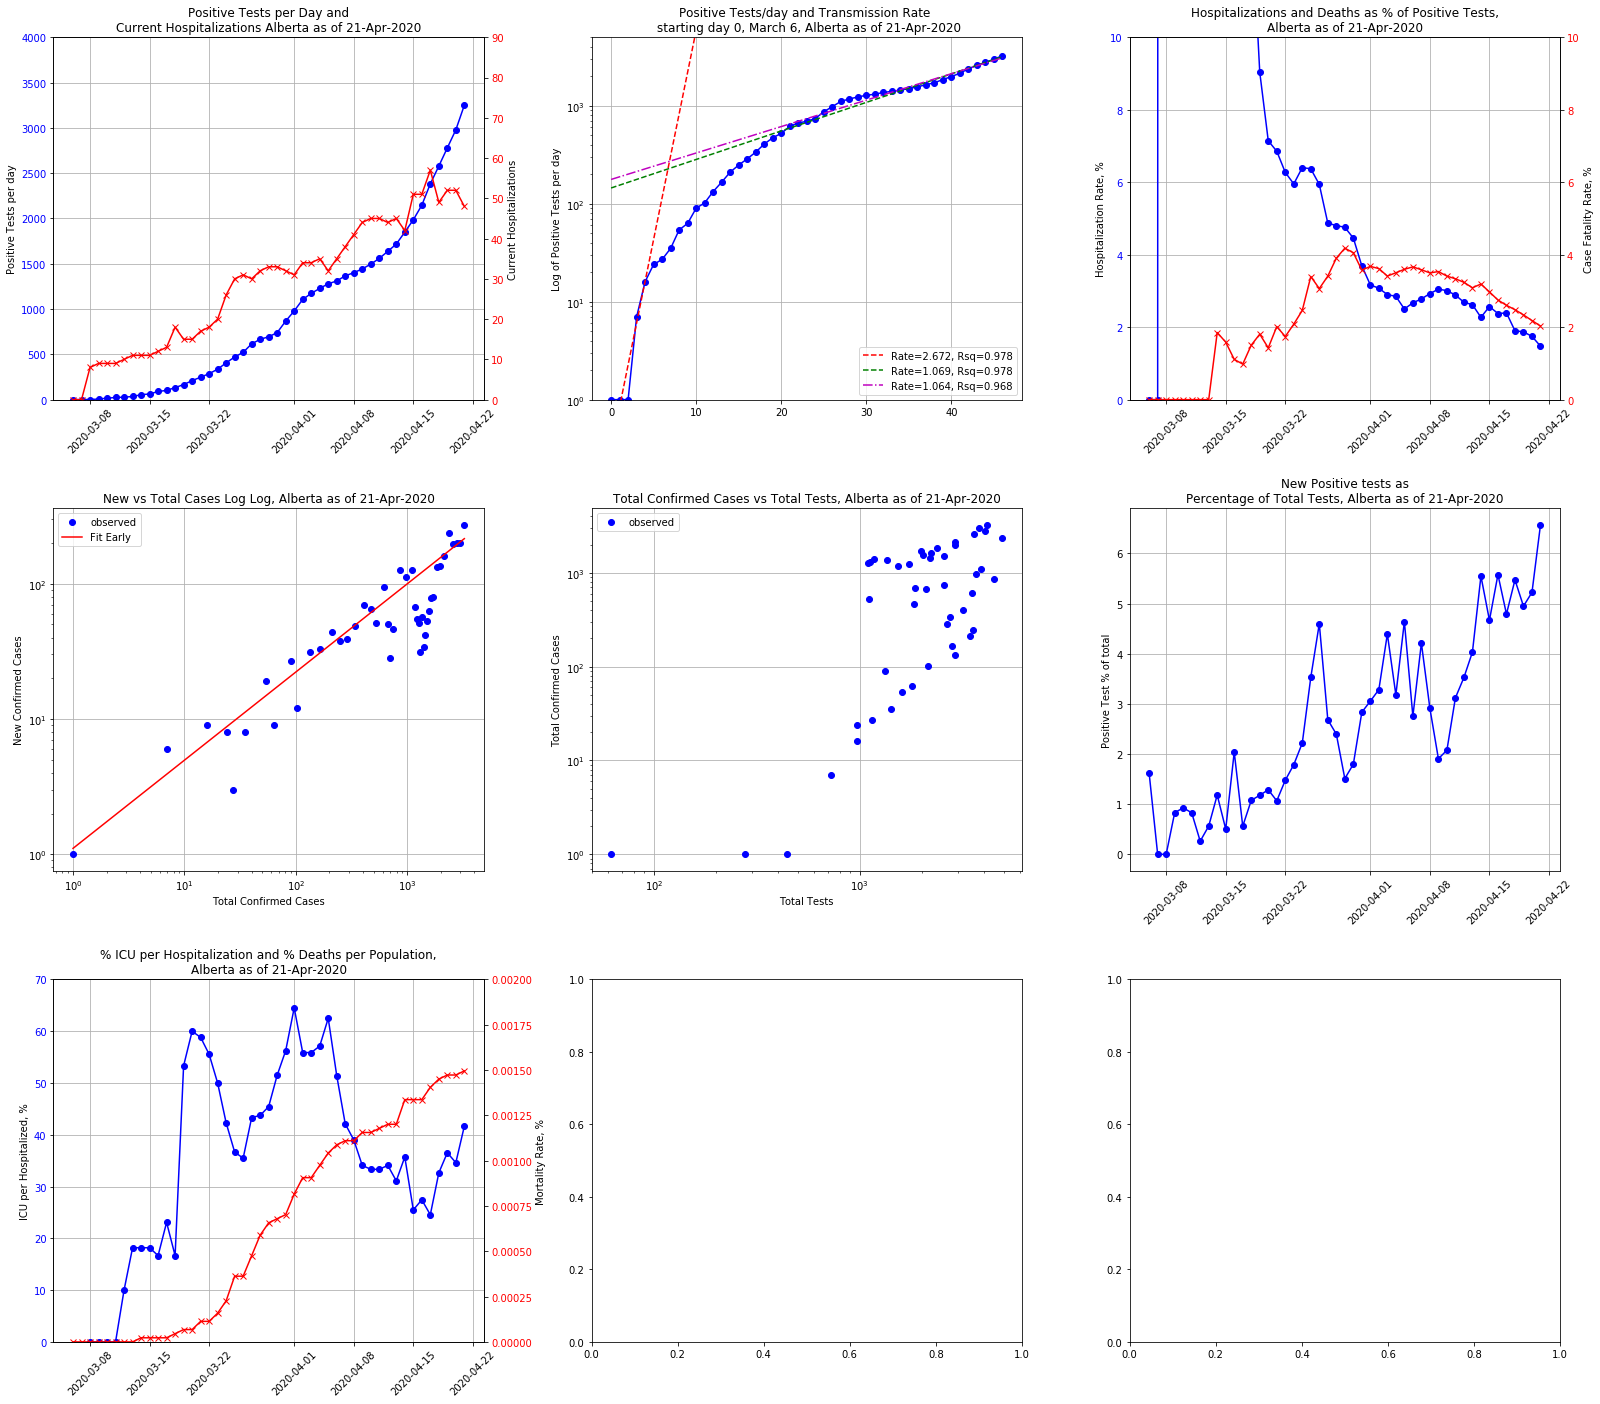

In [31]:
# Get last date in dataframe for graph header
datadate = df.date.iat[-1].strftime("%d-%b-%Y")

def two_scales(ax1,xdata,data1,data2,c1,f1,l1,c2,f2,l2,y1text,y2text):
    ax2 = ax1.twinx()
    ax1.plot(xdata,data1,color=c1,marker=f1,linestyle=l1)
    ax1.set_ylabel(y1text)
    ax2.plot(xdata,data2,color=c2,marker=f2,linestyle=l2)
    ax2.set_ylabel(y2text)
    return ax1,ax2

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9))= plt.subplots(3,3,figsize=(27,24))

ax1, ax1a = two_scales(ax1,df.date,df.TotalPositive,df.Current_Total_Hospitalized,
                       'blue','o','-','red','x','-',
                       'Positive Tests per day','Current Hospitalizations')
ax1.set_title(f"Positive Tests per Day and\nCurrent Hospitalizations Alberta as of {datadate}")
ax1.grid(True)

def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(ax1, 'b')
color_y_axis(ax1a, 'r')
ax1a.set_ylim([0,90])
ax1.set_ylim([0,4000])
ax1.tick_params(axis='x',rotation=45)

ax2.plot(df.index,df.TotalPositive,'-ob')
ax2.set_yscale("log")
ax2.set_title(f"Positive Tests/day and Transmission Rate \n starting day 0, March 6, Alberta as of {datadate}")
ax2.grid(True)
ax2.plot(df.index,transmission_rate(df.index,*ropt),'r--',label=f"Rate={10**(ropt[0]):.3f}, Rsq={earlyrsq:.3f}")
ax2.plot(df.index,transmission_rate(df.index,*ropt2),'g--',label=f"Rate={10**(ropt2[0]):.3f}, Rsq={latersq:.3f}")
ax2.plot(df.index,transmission_rate(df.index,*ropt3),'m-.',label=f"Rate={10**(ropt3[0]):.3f}, Rsq={later_rsq:.3f}")
ax2.set_ylabel("Log of Positive Tests per day")
ax2.legend()
ax2.set_ylim([1,5000])

ax3, ax3a = two_scales(ax3,df.date,df.percHospPerPositiveTest,df.perc_CFR,
                       'blue','o','-','red','x','-',
                       'Hospitalization Rate, %','Case Fatality Rate, %')
ax3.set_title(f"Hospitalizations and Deaths as % of Positive Tests,\nAlberta as of {datadate}")
ax3.grid(True)
color_y_axis(ax3, 'b')
color_y_axis(ax3a, 'r')
ax3a.set_ylim([0,10])
ax3.set_ylim([0,10])
ax3.tick_params(axis='x',rotation=45)

ax4.plot(df.TotalPositive,df.NewPositive,'ob',label='observed')
ax4.set_title(f"New vs Total Cases Log Log, Alberta as of {datadate}")
ax4.set_ylabel("New Confirmed Cases")
ax4.set_xlabel("Total Confirmed Cases")
ax4.grid(True)
ax4.set_yscale("log")
ax4.set_xscale("log")
ax4.plot(df.TotalPositive,llfunc(df.TotalPositive,*p2opt),'r-',label='Fit Early')
ax4.legend()

ax5.plot(df.TotalTests,df.TotalPositive,'ob',label='observed')
ax5.set_title(f"Total Confirmed Cases vs Total Tests, Alberta as of {datadate}")
ax5.set_ylabel("Total Confirmed Cases")
ax5.set_xlabel("Total Tests")
ax5.grid(True)
ax5.set_yscale("log")
ax5.set_xscale("log")
#ax5.plot(df.TotalPositive,llfunc(df.TotalPositive,*p2opt),'r-',label='Fit Early')
ax5.legend()

ax6.plot(df.date,(df.NewPositive/df.TotalTests*100),'-ob')
ax6.set_title(f"New Positive tests as\nPercentage of Total Tests, Alberta as of {datadate}")
ax6.set_ylabel("Positive Test % of total")
ax6.grid(True)
ax6.tick_params(axis='x',rotation=45)

ax7, ax7a = two_scales(ax7,df.date,df.percICUPerHospitalized,df.perc_MortalityRate,
                       'blue','o','-','red','x','-',
                       'ICU per Hospitalized, %','Mortality Rate, %')
ax7.set_title(f"% ICU per Hospitalization and % Deaths per Population,\nAlberta as of {datadate}")
ax7.grid(True)
color_y_axis(ax7, 'b')
color_y_axis(ax7a, 'r')
ax7a.set_ylim([0,.002])
ax7.set_ylim([0,70])
ax7.tick_params(axis='x',rotation=45)

plt.subplots_adjust(wspace=0.25,hspace=0.3)
plt.show()

# Predict ICU Beds and Hosptalizations at Day X

In [27]:
#Input desired Forecast Date:
dates = ['2020-04-29','2020-05-06','2020-05-13','2020-05-20']

In [28]:
def forecast(d):
    
    future = datetime.strptime(d,"%Y-%m-%d")
    elapsed = (future - df.date.iloc[0]).days
    
    # Calculate future positive tests using later transmission rate and hospitalizations and ICU admissions as a function of the positive tests
    pos_tests_future = transmission_rate(elapsed,*ropt2)
    hosp_future = hosp/100*pos_tests_future
    icu_future = icu/100*pos_tests_future
    dead_future1 = dead1/100*pos_tests_future
    dead_future2 = dead2/100*pos_tests_future
    #dead_future3 = dead3/100*pos_tests_future

    # Print results
    print(f"Forecast date: {d}")
    print(f"Yields:\n{pos_tests_future:.0f} positive tests on that day\n{hosp_future:.0f} people in hospital\n{icu_future:.0f} people in ICU\n{dead_future1:.0f}-{dead_future2:.0f} people dead\n")

    return

In [29]:
# Get Current date as last date of data in dataframe
current = df.date.iloc[-1].date()

# Print results
print(f"Last full day of data: {current}")
print(f"Deaths to current date (not forecast): {df.Cumulative_Deaths.iloc[-1]}")
print(f"Mean Hospitalization/positve test {hosp:.2f}% and mean ICU/Positive Test: {icu:.2f}%")
print(f"Using transmission rate of {(10**ropt3[0]):.3f}\n")

for d in dates:
    forecast(d)

Last full day of data: 2020-04-21
Deaths to current date (not forecast): 66
Mean Hospitalization/positve test 8.60% and mean ICU/Positive Test: 1.81%
Using transmission rate of 1.064

Forecast date: 2020-04-29
Yields:
5406 positive tests on that day
465 people in hospital
98 people in ICU
165-176 people dead

Forecast date: 2020-05-06
Yields:
8645 positive tests on that day
744 people in hospital
157 people in ICU
265-282 people dead

Forecast date: 2020-05-13
Yields:
13823 positive tests on that day
1189 people in hospital
251 people in ICU
423-451 people dead

Forecast date: 2020-05-20
Yields:
22102 positive tests on that day
1901 people in hospital
401 people in ICU
677-721 people dead



# Extra Code

In [30]:
# By mean age - WAY TOO LOW
mean_age = 37.1  # Statista
# The lancet data on age and CFR (%):
ageCFR = {}

for i in range(0,10):
    ageCFR[i] = 0.005
for i in range(10,20):
    ageCFR[i] = 0.01
for i in range(20,30):
    ageCFR[i] = 0.06
for i in range(30,40):
    ageCFR[i] = 0.14
for i in range(40,50):
    ageCFR[i] = 0.29
for i in range(50,60):
    ageCFR[i] = 1.2
for i in range(60,70):
    ageCFR[i] = 3.9
for i in range(70,80):
    ageCFR[i] = 8.6
for i in range(80,101):
    ageCFR[i] = 13.4

# make two lists for interpolation
age = []
avgCFR = []
for key,value in ageCFR.items():
    age.append(key)
    avgCFR.append(value)

# Interpolate for average Albertan:
interp_age_CFR = scipy.interpolate.interp1d(age,avgCFR)
dead3 = interp_age_CFR(mean_age)